<a href="https://colab.research.google.com/github/LorenzoPolli/market-basket-analysis/blob/main/A_Priori_%26_SON_Market_basket_analysis_(eng_newspapers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frequent itemset Mining (Market-basket analysis)

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing the MeDAL dataset described in Project 1. The detector must consider as baskets the strings contained in the text column of the  full-data.csv file in the dataset, using words as items

> Project author: Samuel Mesfin Tsegai

Algorithms for Massive Data


*Università degli Studi di Milano*


06-September-2023


## **FP Growth , A-Priori  & PCY Algorithms**

### **1. Setup and data import**

In [1]:
!pip install --upgrade kaggle
from google.colab import files

# Upload Kaggle API key
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files(dataset='xhlulu/medal-emnlp' ,quiet=False,unzip=True)

100%|██████████| 6.82G/6.82G [03:56<00:00, 31.0MB/s]


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"


In [4]:
!pip install pyspark==3.0.3
!pip install spark-nlp==3.1.1
!pip install py4j==0.10.9


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.1/209.1 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 23.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435950 sha256=eef6e4576facaf494c09b436afc9efe5cf18f3512b83564c752504cf5df7ca91
  Stored in directory: /root/.cache/pip/wheels/40/50/14/79047c3c171b701e591d287b78a201214d9c8e0b93fef64458
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.8 MB/s eta 0:00:00


#### **1.1 Setting up PySpark and Spark NLP**


In [5]:
%%time
import sparknlp

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.1.1
Apache Spark version: 3.0.3
CPU times: user 444 ms, sys: 819 ms, total: 1.26 s
Wall time: 26.5 s


In [6]:
# Check Spark environment

spark

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

#### **1.2. Import the dataset**

In [8]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType

# Specify the schema
schema = StructType([
    StructField("TEXT", StringType()),
    StructField("LOCATION", StringType()),
    StructField("LABEL", StringType())
])

# Retrieve the datase
df = spark.read.csv("full_data.csv", schema=schema, header=True, sep=",")

# Select the column "text"
df = df.select("TEXT")

In [9]:
# Check

%%time
df.show()

+--------------------+
|                TEXT|
+--------------------+
|alphabisabolol ha...|
|a report is given...|
|the virostatic co...|
|rmi rmi and rmi a...|
|a doubleblind stu...|
|stroma from eithe...|
|the effect of the...|
|in one experiment...|
|the presence of a...|
|the reaction of g...|
|choline acetyltra...|
|increasing concen...|
|the properties of...|
|primary amines re...|
|a purification pr...|
|dihydrofolate red...|
|ionization effect...|
|kinetic analyses ...|
|the nearultraviol...|
|the circular pola...|
+--------------------+
only showing top 20 rows

CPU times: user 11.6 ms, sys: 2.02 ms, total: 13.6 ms
Wall time: 1.9 s


In [10]:
# Take a sample of the DataFrame
sample_df = df.sample(fraction=0.002, seed=123)  # Adjust the fraction as per your needs

In [11]:
sample_df.show()

+--------------------+
|                TEXT|
+--------------------+
|the modified proc...|
|dopamine betahydr...|
|the effects of th...|
|an aminopeptidase...|
|phenacetin parace...|
|some properties o...|
|a TR inhibitor wa...|
|investigations we...|
|to clarify the ro...|
|the formation of ...|
|thyrotropin mum i...|
|the metabolic act...|
|the phdependence ...|
|sodium cyanide wa...|
|three benzodiazep...|
|four hundred cons...|
|crude hirudin pre...|
|some properties o...|
|eight pregnant wo...|
|the effect of hyp...|
+--------------------+
only showing top 20 rows



### **2. Pre-processing**

pre-processing text data from a sample_df DataFrame. After the transformations, the text will be in a tokenized, normalized, stop-word-free, and lemmatized format. This kind of preprocessing is typical in NLP tasks to clean and prepare text data for further analysis or modeling

#### Importing required libraries and modules:
importing various modules and functions necessary for data processing, NLP operations, and creating ML pipelines using PySpark

In [12]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.sql.functions import monotonically_increasing_id
from sparknlp.annotator import *
from sparknlp.base import *


#### Selecting a column from a DataFrame:

In [13]:
text_df = sample_df.select("TEXT")

#### Initializing NLP annotators:


In [14]:
# Initialize the annotators
# DocumentAssembler: Converts the text column into a format that Spark NLP can work with.
document_assembler = DocumentAssembler() \
    .setInputCol("TEXT") \
    .setOutputCol("document")

# SentenceDetector: Splits the text into sentences.
sentence_detector = SentenceDetector() \
    .setInputCols(['document']) \
    .setOutputCol('sentence')

# Tokenizer: Splits the sentences into words or tokens.
tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

# Normalizer: Removes punctuations and other non-alphanumeric characters and optionally lowercases the tokens
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

# StopWordsCleaner: Removes common words (stop words) that do not add significant meaning, e.g., "and", "the", etc
stop_words_cleaner = StopWordsCleaner.pretrained('stopwords_en', 'en') \
    .setInputCols(["normalized"]) \
    .setOutputCol("cleanTokens")

# Lemmatizer: Converts words into their base or dictionary form. For instance, "running" becomes "run"
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")


stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


#### User-defined function to remove duplicates:

This user-defined function (UDF) converts a list into a set (which removes duplicates) and then converts the set back into a list.

In [15]:
remove_duplicates = F.udf(lambda x: list(set(x)), ArrayType(StringType()))

### Creating a preprocessing pipeline:

In [16]:
preprocessing_pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    stop_words_cleaner,
    lemmatizer])


### **3. Exploratory Data Analysis**

In [17]:
# Create a temporary view for DataFrame
sample_df.createOrReplaceTempView("sample_view")

# Count the number of unique documents

total_rows = spark.sql("""SELECT COUNT(DISTINCT TEXT) AS total_rows
                        FROM sample_view""")
total_rows.show()


+----------+
|total_rows|
+----------+
|     28377|
+----------+



In [18]:

# Fit the pipeline
pipeline_model = preprocessing_pipeline.fit(text_df)

# Transform the data
preprocessed_data = pipeline_model.transform(text_df)

# Select the "result" field from the lemma column
preprocessed_data = preprocessed_data.withColumn("lemmas", F.col("lemma.result"))

# Remove duplicate words
deduplicated_data = preprocessed_data.withColumn("items", remove_duplicates(F.col("lemmas")))

# Add index column
indexed_data = deduplicated_data.withColumn("Index", monotonically_increasing_id())

# Show the indexed data
indexed_data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|                TEXT|            document|            sentence|               token|          normalized|         cleanTokens|               lemma|              lemmas|               items|Index|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|the modified proc...|[[document, 0, 10...|[[document, 0, 10...|[[token, 0, 2, th...|[[token, 0, 2, th...|[[token, 4, 11, m...|[[token, 4, 11, m...|[modify, procedur...|[result, protein,...|    0|
|dopamine betahydr...|[[document, 0, 28...|[[document, 0, 28...|[[token, 0, 7, do...|[[token, 0, 7, do...|[[token, 0, 7, do...|[[token, 0, 7, do...|[dopamine, betahy...|[result, importan...|    1|
|the effects of

In [19]:

indexed_data.cache()

DataFrame[TEXT: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, sentence: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, normalized: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, cleanTokens: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemma: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, lemmas: array<string>, items: array<string>, Index: bigint]

Checking number of cores for paralle computing

In [20]:
!cat /proc/cpuinfo | grep processor | wc -l


8


### **1. Market-Basket Analysis (Frequent Itemset Mining)**

### **1. FP Growrth-algorithm**

FP-Growth is an algorithm designed to find frequent itemsets in a dataset, which in this context represents sets of items frequently purchased together in transactions.

In [62]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as F

# Apply FP-Growth algorithm with adjusted parameters
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.02, numPartitions=8)
model = fpGrowth.fit(indexed_data)

# Get all frequent itemsets
frequent_itemsets = model.freqItemsets

# Print the frequent itemsets
for row in frequent_itemsets.take(20):
    print(f"Frequent itemset: {row['items']}, freq: {row['freq']}")


Frequent itemset: ['direct'], freq: 1202
Frequent itemset: ['advance'], freq: 695
Frequent itemset: ['physiological'], freq: 618
Frequent itemset: ['cancer'], freq: 1565
Frequent itemset: ['cancer', 'cell'], freq: 717
Frequent itemset: ['cancer', 'patient'], freq: 639
Frequent itemset: ['cancer', 'study'], freq: 653
Frequent itemset: ['receptor'], freq: 1820
Frequent itemset: ['receptor', 'suggest'], freq: 579
Frequent itemset: ['receptor', 'show'], freq: 633
Frequent itemset: ['receptor', 'increase'], freq: 618
Frequent itemset: ['receptor', 'cell'], freq: 915
Frequent itemset: ['receptor', 'result'], freq: 685
Frequent itemset: ['receptor', 'effect'], freq: 720
Frequent itemset: ['receptor', 'study'], freq: 718
Frequent itemset: ['efficacy'], freq: 643
Frequent itemset: ['tumor'], freq: 1310
Frequent itemset: ['tumor', 'cell'], freq: 724
Frequent itemset: ['material'], freq: 727
Frequent itemset: ['factor'], freq: 3247


In [63]:

# Get association rules
association_rules = model.associationRules

# Print association rules using show()
association_rules.show()


+-----------------+----------+------------------+------------------+
|       antecedent|consequent|        confidence|              lift|
+-----------------+----------+------------------+------------------+
|          [amino]|    [acid]|0.9158878504672897|12.323446909772537|
|     [play, cell]|    [role]| 0.984984984984985|  8.10171562867215|
|    [play, study]|    [role]|0.9715568862275449| 7.991266597240301|
|  [proliferation]|    [cell]|0.8617176128093159| 3.727017329475683|
|           [play]|    [role]|0.9686500319897633| 7.967357089209713|
|[play, important]|    [role]|0.9837133550488599| 8.091256196006231|
+-----------------+----------+------------------+------------------+



Based on these metrics, we can conclude that there are significant associations between the antecedent and consequent itemsets mentioned in the table. The high confidence, lift, and support values suggest strong relationships and frequent occurrences of these itemsets in the dataset

### **EDA**

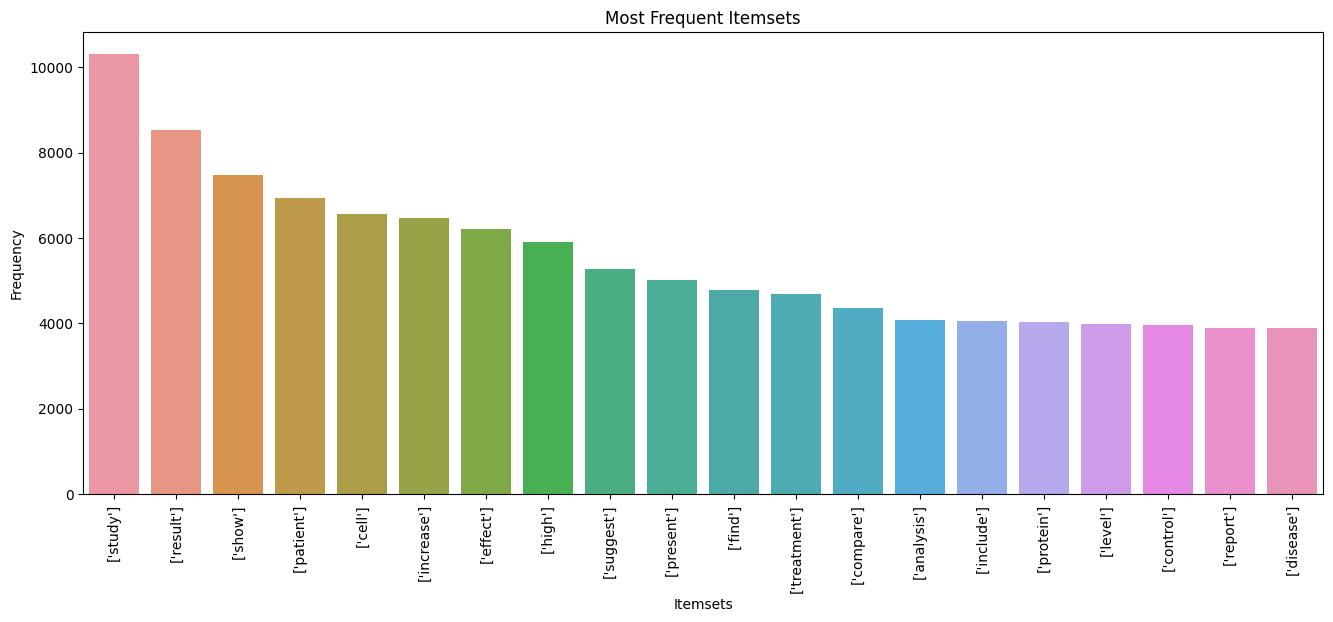

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert frequent itemsets to pandas DataFrame
freq_itemsets_df = frequent_itemsets.toPandas()

# Convert the 'items' column to a string representation
freq_itemsets_df['items'] = freq_itemsets_df['items'].astype(str)

# Sort the itemsets based on frequency in descending order
sorted_itemsets_df = freq_itemsets_df.sort_values('freq', ascending=False)

# Plot the frequency of the most frequent itemsets
plt.figure(figsize=(16, 6))
sns.barplot(data=sorted_itemsets_df.head(20), x='items', y='freq')
plt.title('Most Frequent Itemsets')
plt.xlabel('Itemsets')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


              items   freq
285       ['study']  10306
440      ['result']   8525
603        ['show']   7476
950     ['patient']   6926
1075       ['cell']   6561
1292   ['increase']   6477
1676     ['effect']   6212
1817       ['high']   5895
40      ['suggest']   5262
477     ['present']   5008
666        ['find']   4792
815   ['treatment']   4687
1193    ['compare']   4348
1334   ['analysis']   4070
1528    ['include']   4065
1910    ['protein']   4023
165       ['level']   3992
324     ['control']   3952
711      ['report']   3902
881     ['disease']   3898


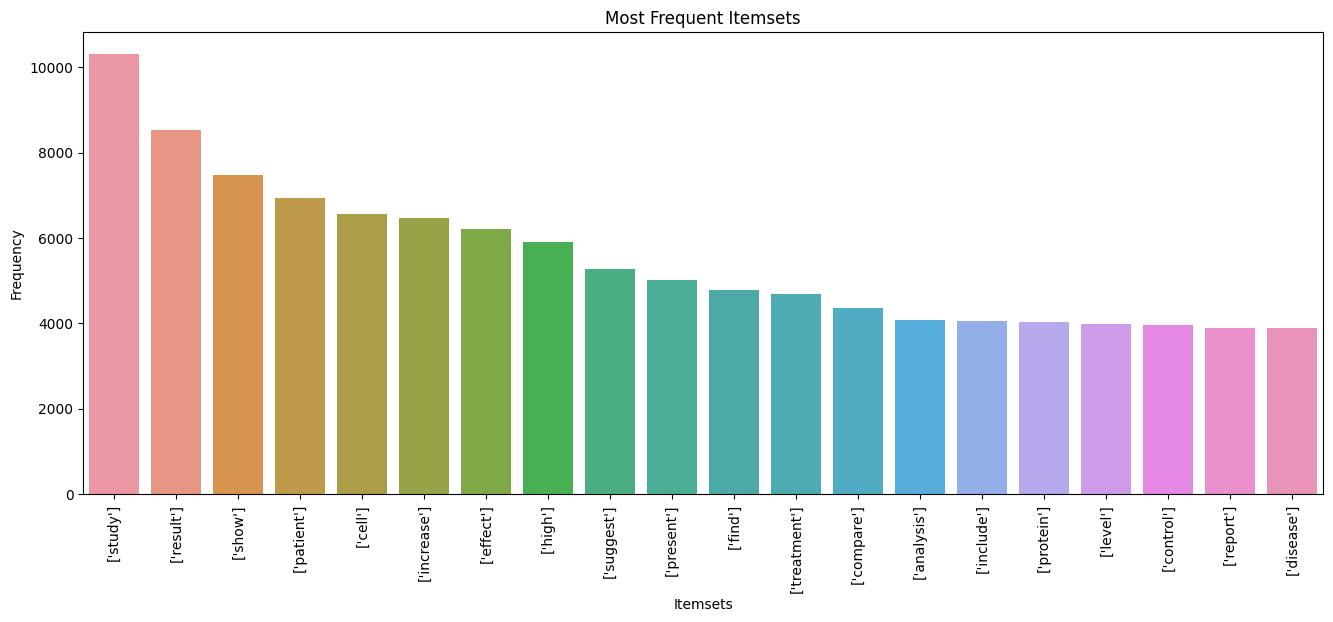

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert frequent itemsets to pandas DataFrame
freq_itemsets_df = frequent_itemsets.toPandas()

# Convert the 'items' column to a string representation
freq_itemsets_df['items'] = freq_itemsets_df['items'].astype(str)

# Sort the itemsets based on frequency in descending order
sorted_itemsets_df = freq_itemsets_df.sort_values('freq', ascending=False)

# Print the top 20 frequent itemsets
print(sorted_itemsets_df.head(20))

# Plot the frequency of the most frequent itemsets
plt.figure(figsize=(16, 6))
sns.barplot(data=sorted_itemsets_df.head(20), x='items', y='freq')
plt.title('Most Frequent Itemsets')
plt.xlabel('Itemsets')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


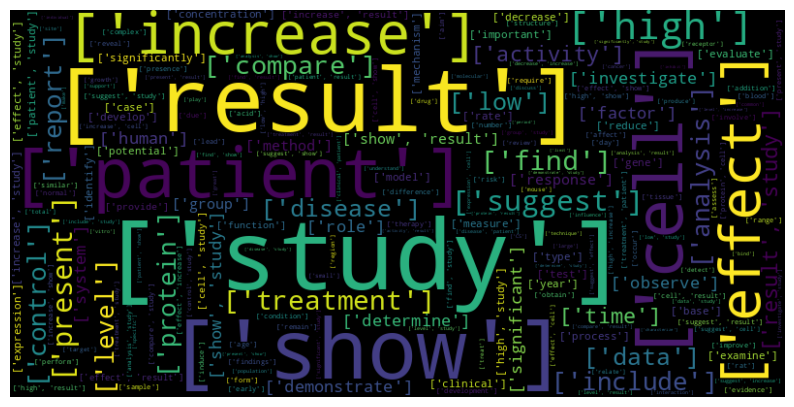

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of items and their frequencies
items_freq = freq_itemsets_df.set_index('items').freq.to_dict()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=100).generate_from_frequencies(items_freq)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


The pie chart shows the rule coverage using the 'support' metric for each rule.

In [67]:
#Convert association_rules to Pandas DataFrame:

association_rules_data = association_rules.toPandas()
print(association_rules_data.columns)
print(association_rules_data.head())



Index(['antecedent', 'consequent', 'confidence', 'lift'], dtype='object')
        antecedent consequent  confidence       lift
0          [amino]     [acid]    0.915888  12.323447
1     [play, cell]     [role]    0.984985   8.101716
2    [play, study]     [role]    0.971557   7.991267
3  [proliferation]     [cell]    0.861718   3.727017
4           [play]     [role]    0.968650   7.967357


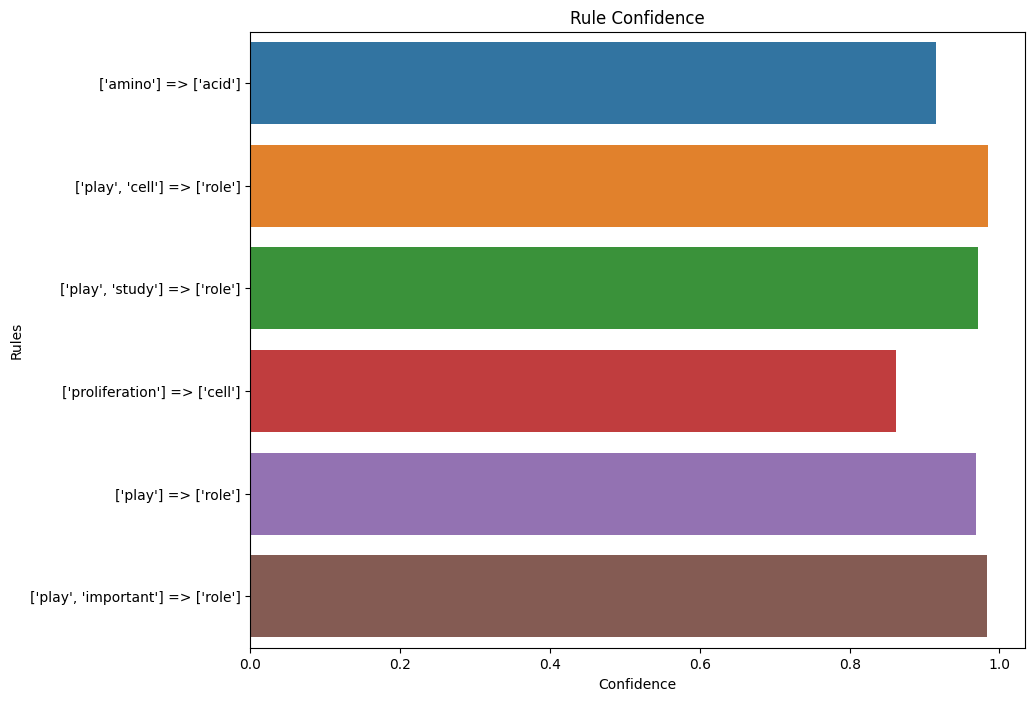

In [68]:
# Define the labels
labels = association_rules_data['antecedent'].astype(str) + " => " + association_rules_data['consequent'].astype(str)

# Plotting the bar chart using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(data=association_rules_data, y=labels, x='confidence', orient='h')
plt.title('Rule Confidence')
plt.xlabel('Confidence')
plt.ylabel('Rules')
plt.show()


Bar plot to visualize the support metric for association rules.
Pie chart to represent the rule coverage using the support metric.
Scatter plot to visualize the relationship between confidence and lift metrics for association rules.
Network graph to visualize the association rules as nodes and edges with confidence as edge labels.
Word cloud to display the frequent itemsets with larger words representing higher frequencies.

Rule Evaluation and Ranking: Extend the analysis by evaluating the association rules using metrics like lift, conviction, and leverage. These metrics can provide insights into the strength, significance, and impact of the rules. Calculate these metrics for each rule and rank them to identify the most influential and actionable rules.

Visualization Enhancements: Explore various visualization techniques to present the association rules and frequent itemsets more effectively. Consider using interactive visualizations that allow users to explore and interact with the rules dynamically. Use libraries like Plotly or D3.js to create visually appealing and informative visualizations.

In [69]:
import plotly.express as px

# Convert the PySpark DataFrame to a pandas DataFrame
association_rules_pd = association_rules.toPandas()

# Convert list columns to string
association_rules_pd['antecedent_str'] = association_rules_pd['antecedent'].astype(str)
association_rules_pd['consequent_str'] = association_rules_pd['consequent'].astype(str)

# Create labels for the hover name, combining antecedent and consequent
association_rules_pd['rule'] = association_rules_pd['antecedent_str'] + " => " + association_rules_pd['consequent_str']

# Interactive Visualization with Plotly
fig = px.scatter(association_rules_pd,
                 x='confidence',
                 y='lift',
                 color='antecedent_str',   # Using the string version of antecedent for color
                 hover_name='rule',        # Using the created rule for hover
                 log_x=True,
                 log_y=True)
fig.update_layout(title='Interactive Scatter Plot: Confidence vs. Lift',
                  xaxis_title='Confidence',
                  yaxis_title='Lift')
fig.show()


 Now that we have evaluated the association rules and enhanced the visualizations, the next step could be to apply rule filtering and refinement. This will help you focus on the most meaningful and actionable rules.

Here's how you can proceed with rule filtering and refinement:

Set Thresholds: Determine the thresholds for support, confidence, lift, or any other metrics that you consider important for your analysis. These thresholds will define the criteria for filtering the association rules.

Filter Rules: Apply the thresholds to filter the association rules based on the selected metrics. Keep only the rules that meet or exceed the specified thresholds. This step will help you narrow down the rules to the most significant ones.

Refine Rules: Explore additional refinements or transformations on the filtered rules to enhance their interpretability or usefulness. For example, you can simplify the rules by removing redundant or subsumed rules, or you can combine similar rules to create more general rules.

Evaluate the Refined Rules: Calculate the metrics for the refined rules and assess their quality and usefulness. You can compare the refined rules with the original rules to understand the impact of the filtering and refinement process.

#### **2. A-priori Algorithm step by step Implementation**

In [70]:
from pyspark.sql import SparkSession
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [71]:
# 2. Convert the DataFrame to an RDD
# -------------------------------------
# 'indexed_data' is a DataFrame, and its "items" column (which is a list of items) is converted to an RDD.
rdd_baskets = indexed_data.select("items").rdd


In [72]:
# 3. Filter out Empty Baskets
# -------------------------------------
# Some baskets (lists of items) might be empty. We don't want them, so we filter them out.
rdd_baskets = rdd_baskets.filter(lambda x: len(x[0]) != 0)


In [73]:
# 4. Flatten the Lists
# -------------------------------------
# Each basket might have multiple items. We flatten it to have one item per row.
flat_list = rdd_baskets.flatMap(lambda xs: xs[0])


In [74]:
# 5. Compute Basic Statistics for Support Calculation
# -----------------------------------------------------
# Counting the total number of baskets (or transactions).
total_transactions = rdd_baskets.count()

# Calculating the minimum support. It is set to 2% of total transactions.
minSupport = total_transactions * 0.02


In [75]:
# 6. Create Singletons (First pass of Apriori Algorithm)
# -------------------------------------------------------
# Mapping each item to a key-value pair: the key is the item itself, the value is 1 (for counting).
singletons = flat_list.map(lambda item: (item, 1))

# Summing up the values for each key (item) to compute the frequency of each item.
singletons_sum = singletons.reduceByKey(lambda x, y: x + y)

# Filtering out the items that have frequencies less than the minimum support.
singletons_filtered = singletons_sum.filter(lambda item: item[1] >= minSupport)

# Extracting the frequent items from the filtered list.
frequent_items = singletons_filtered.map(lambda item: item[0])


In [76]:
# 7. Display Intermediate and Final Results
# ----------------------------------------------
# These print statements show samples from the various RDDs and final frequent items.
# It helps in debugging and understanding the progression.
print("rdd_baskets:", rdd_baskets.take(20))               # Displaying the first 20 baskets
print("flat_list:", flat_list.take(20))                   # Displaying the first 20 items after flattening
print("singletons:", singletons.take(20))                 # Displaying the first 20 (item, 1) pairs


rdd_baskets: [Row(items=['result', 'protein', 'concentration', 'presence', 'middle', 'velocity', 'profile', 'nacl', 'distribution', 'discuss', 'equilibrium', 'oligomer', 'observe', 'dissociate', 'buffer', 'citrate', 'phosphofructokinase', 'elute', 'specifically', 'sedimentation', 'artifact', 'transport', 'point', 'specific', 'formaldehyde', 'elution', 'range', 'view', 'utioizing', 'conformer', 'trisedtaphosphate', 'evidence', 'possibility', 'slow', 'experiment', 'fraction', 'muscle', 'reveal', 'purification', 'formalinization', 'rabbit', 'method', 'formalinized', 'complex', 'disc', 'pattern', 'skeletal', 'rechromatography', 'procedure', 'present', 'component', 'work', 'deaecellulose', 'characterize', 'superposition', 'interconvertibility', 'electrophoresis', 'schlieren', 'characteristic', 'mm', 'pfk', 'demonstrate', 'high', 'modify', 'resolve', 'ph']), Row(items=['result', 'important', 'NS', 'control', 'concept', 'pressure', 'blood', 'adrenal', 'gland', 'dopamine', 'vessel', 'activity'

In [77]:
print("singletons_sum:", singletons_sum.take(20))         # Displaying the first 20 items with their counts
print("singletons_filtered:", singletons_filtered.take(20)) # Displaying the first 20 frequent items with their counts
print("frequent_items:", frequent_items.collect())       # Displaying all frequent items


singletons_sum: [('schlieren', 1), ('hydroxytryptamine', 26), ('develop', 2999), ('bird', 112), ('ALP', 52), ('nuclear', 562), ('spin', 93), ('major', 1287), ('concomitant', 188), ('pyruvate', 54), ('benzydamine', 1), ('definition', 154), ('ac', 76), ('podophyllotoxinagents', 1), ('precede', 180), ('core', 333), ('explicitly', 39), ('stabilize', 240), ('thoracotomy', 26), ('joint', 314)]
singletons_filtered: [('develop', 2999), ('major', 1287), ('reflect', 599), ('field', 887), ('efficacy', 643), ('work', 1281), ('suggest', 5262), ('acid', 2109), ('IB', 674), ('record', 779), ('TPS', 866), ('alternative', 628), ('stress', 779), ('feature', 1144), ('acute', 1126), ('good', 815), ('exhibit', 1275), ('cellular', 1054), ('laboratory', 604), ('position', 636)]
frequent_items: ['develop', 'major', 'reflect', 'field', 'efficacy', 'work', 'suggest', 'acid', 'IB', 'record', 'TPS', 'alternative', 'stress', 'feature', 'acute', 'good', 'exhibit', 'cellular', 'laboratory', 'position', 'RT', 'limit'

In [78]:
# 8. Generate Pairs from each Basket
# ---------------------------------------------
# For each basket, generate all possible pairs of items.
# This creates pairs of items like ((item1, item2), 1) indicating item1 and item2 appear together in a transaction.
pairs = rdd_baskets.flatMap(lambda x: [((x[0][i], x[0][j]), 1) for i in range(len(x[0])) for j in range(i+1, len(x[0]))])


In [79]:
# 9. Count Frequency of Each Pair
# ----------------------------------
# Using reduceByKey, sum up the 1's for each unique pair to get its frequency.
pair_counts = pairs.reduceByKey(lambda x, y: x + y)


In [81]:
# 10. Filter out Non-frequent Pairs
# --------------------------------------
# Keep only those pairs whose frequency is greater than or equal to the minimum support.
frequent_pairs = pair_counts.filter(lambda item: item[1] >= minSupport)


In [82]:
# 11. Convert RDD to DataFrame
# ---------------------------------
# Convert the frequent_pairs RDD to a DataFrame for better representation and further analysis.
freq_pairs_df = spark.createDataFrame(frequent_pairs, ["items", "freq"])
freq_pairs_pandas_df = freq_pairs_df.toPandas()

In [83]:
# 12. Convert Spark DataFrame to Pandas DataFrame
# ---------------------------------------------------
# This conversion facilitates easier data manipulation and plotting using libraries like matplotlib or seaborn.
freq_pairs_pandas_df = freq_pairs_df.toPandas()


In [84]:
# 13. Sorting Pairs based on Frequency
# ---------------------------------------
# Sort the pairs in descending order based on their frequency.
sorted_pairs_df = freq_pairs_pandas_df.sort_values('freq', ascending=False)


In [85]:
# 14. Display Results
# -----------------------
# These print statements show the frequent item pairs and their frequencies.
print("frequent_pairs: ", frequent_pairs.take(20))        # Displaying the first 20 frequent pairs with their counts
print("freq_pairs_df: ", freq_pairs_df.show(20))          # Displaying the first 20 rows of the Spark DataFrame
print("sorted_pairs_df: ")                                # Displaying the top 20 pairs from the sorted Pandas DataFrame
print(sorted_pairs_df.head(20))


frequent_pairs:  [(('show', 'study'), 1612), (('result', 'group'), 1163), (('result', 'develop'), 941), (('study', 'determine'), 822), (('include', 'disease'), 826), (('case', 'patient'), 939), (('cell', 'decrease'), 932), (('identify', 'include'), 662), (('group', 'patient'), 618), (('evaluate', 'increase'), 646), (('protein', 'acid'), 609), (('show', 'lead'), 717), (('significant', 'study'), 1670), (('significant', 'low'), 684), (('cell', 'control'), 625), (('find', 'identify'), 661), (('data', 'base'), 581), (('identify', 'analysis'), 798), (('study', 'lead'), 897), (('reveal', 'suggest'), 655)]
+--------------------+----+
|               items|freq|
+--------------------+----+
|       [show, study]|1612|
|     [result, group]|1163|
|   [result, develop]| 941|
|  [study, determine]| 822|
|  [include, disease]| 826|
|     [case, patient]| 939|
|    [cell, decrease]| 932|
| [identify, include]| 662|
|    [group, patient]| 618|
|[evaluate, increase]| 646|
|     [protein, acid]| 609|
| 

In [86]:
# Obtain the top 20 frequent items
top20_frequent_items = singletons_filtered.sortBy(lambda x: x[1], ascending=False).take(20)

# Print the top 20 frequent items
print("Top 20 frequent items:")
for item, count in top20_frequent_items:
    print(f"Item: {item}, Count: {count}")


Top 20 frequent items:
Item: study, Count: 10306
Item: result, Count: 8525
Item: show, Count: 7476
Item: patient, Count: 6926
Item: cell, Count: 6561
Item: increase, Count: 6477
Item: effect, Count: 6212
Item: high, Count: 5895
Item: suggest, Count: 5262
Item: present, Count: 5008
Item: find, Count: 4792
Item: treatment, Count: 4687
Item: compare, Count: 4348
Item: analysis, Count: 4070
Item: include, Count: 4065
Item: protein, Count: 4023
Item: level, Count: 3992
Item: control, Count: 3952
Item: report, Count: 3902
Item: disease, Count: 3898


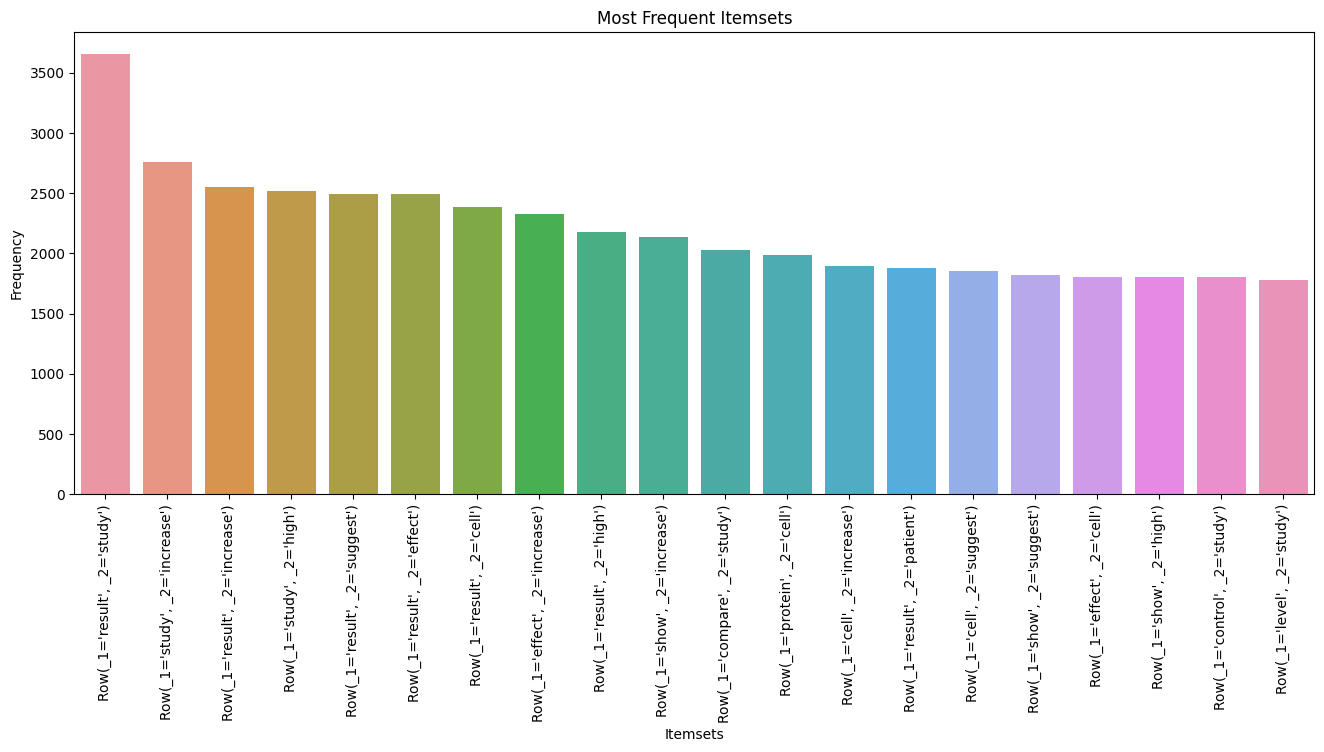

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'items' column to a string representation
sorted_pairs_df['items'] = sorted_pairs_df['items'].astype(str)

# Sort the pairs based on frequency in descending order
sorted_pairs_df = sorted_pairs_df.sort_values('freq', ascending=False)

# Plot the frequency of the most frequent itemsets
plt.figure(figsize=(16, 6))
sns.barplot(data=sorted_pairs_df.head(20), x='items', y='freq')
plt.title('Most Frequent Itemsets')
plt.xlabel('Itemsets')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


### **3.PCY  algorithm step by step Implementation**

The PCY (Park-Chen-Yu) algorithm is an improvement to the Apriori algorithm for frequent itemset mining. The main idea behind PCY is to reduce the number of candidate pairs in the second pass by using a hashing technique during the first pass

In [88]:
from pyspark.sql import SparkSession
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [89]:

# 2. Convert the DataFrame to an RDD
rdd_baskets = indexed_data.select("items").rdd



In [90]:
# 3. Filter out Empty Baskets
rdd_baskets = rdd_baskets.filter(lambda x: len(x[0]) != 0)



In [91]:
# 4. Flatten the Lists
flat_list = rdd_baskets.flatMap(lambda xs: xs[0])



In [92]:
# 5. Compute Basic Statistics for Support Calculation
total_transactions = rdd_baskets.count()
minSupport = total_transactions * 0.02



In [93]:
# This hash table will be used to count the occurrence of hashed pairs
hash_table_size = 10000  # This is arbitrary. Adjust based on your data.
hash_table = [0] * hash_table_size

def hash_pair(pair):
    return (hash(pair[0]) + hash(pair[1])) % hash_table_size

# Populate the hash table using pairs from the original baskets
for basket in rdd_baskets.collect():
    for pair in combinations(basket[0], 2):
        hash_table[hash_pair(pair)] += 1


##### 2. Second Pass

In [94]:
bitmap = [1 if count >= minSupport else 0 for count in hash_table]

In [95]:

# 7. Generate Singletons (First pass of Apriori Algorithm)
singletons = flat_list.map(lambda item: (item, 1))
singletons_sum = singletons.reduceByKey(lambda x, y: x + y)
singletons_filtered = singletons_sum.filter(lambda item: item[1] >= minSupport)



In [96]:
# 8. Generate Pairs from each Basket
pairs = rdd_baskets.flatMap(lambda x: [((x[0][i], x[0][j]), 1) for i in range(len(x[0])) for j in range(i+1, len(x[0])) if bitmap[hash_pair((x[0][i], x[0][j]))] == 1])


In [97]:
# 9. Count Frequency of Each Pair
pair_counts = pairs.reduceByKey(lambda x, y: x + y)



In [98]:
# 10. Filter out Non-frequent Pairs
frequent_pairs = pair_counts.filter(lambda item: item[1] >= minSupport)



In [99]:
# 11. Convert RDD to DataFrame
freq_pairs_df = spark.createDataFrame(frequent_pairs, ["items", "freq"])
freq_pairs_pandas_df = freq_pairs_df.toPandas()

# Additional display or debugging, if required
print("rdd_baskets:", rdd_baskets.take(20))
print("flat_list:", flat_list.take(20))
print("singletons:", singletons.take(20))


rdd_baskets: [Row(items=['result', 'protein', 'concentration', 'presence', 'middle', 'velocity', 'profile', 'nacl', 'distribution', 'discuss', 'equilibrium', 'oligomer', 'observe', 'dissociate', 'buffer', 'citrate', 'phosphofructokinase', 'elute', 'specifically', 'sedimentation', 'artifact', 'transport', 'point', 'specific', 'formaldehyde', 'elution', 'range', 'view', 'utioizing', 'conformer', 'trisedtaphosphate', 'evidence', 'possibility', 'slow', 'experiment', 'fraction', 'muscle', 'reveal', 'purification', 'formalinization', 'rabbit', 'method', 'formalinized', 'complex', 'disc', 'pattern', 'skeletal', 'rechromatography', 'procedure', 'present', 'component', 'work', 'deaecellulose', 'characterize', 'superposition', 'interconvertibility', 'electrophoresis', 'schlieren', 'characteristic', 'mm', 'pfk', 'demonstrate', 'high', 'modify', 'resolve', 'ph']), Row(items=['result', 'important', 'NS', 'control', 'concept', 'pressure', 'blood', 'adrenal', 'gland', 'dopamine', 'vessel', 'activity'

In [100]:

# 1. Extract top 20 frequent pairs
top_20_frequent_pairs = frequent_pairs.takeOrdered(20, key=lambda x: -x[1])

# 2. Convert to pandas DataFrame
freq_pairs_df = pd.DataFrame(top_20_frequent_pairs, columns=["items", "freq"])

# 3. Visualize
sorted_pairs_df = freq_pairs_df.sort_values('freq', ascending=False)


In [101]:
# 14. Display Results
# -----------------------

# Displaying the first 20 frequent pairs with their counts from the RDD.
print("frequent_pairs:", frequent_pairs.take(20))



frequent_pairs: [(('show', 'study'), 1612), (('result', 'group'), 1163), (('result', 'develop'), 941), (('study', 'determine'), 822), (('include', 'disease'), 826), (('case', 'patient'), 939), (('cell', 'decrease'), 932), (('identify', 'include'), 662), (('group', 'patient'), 618), (('evaluate', 'increase'), 646), (('protein', 'acid'), 609), (('show', 'lead'), 717), (('significant', 'study'), 1670), (('significant', 'low'), 684), (('cell', 'control'), 625), (('find', 'identify'), 661), (('data', 'base'), 581), (('identify', 'analysis'), 798), (('study', 'lead'), 897), (('reveal', 'suggest'), 655)]


In [102]:

# If freq_pairs_df is already a pandas DataFrame, just display it.
# Displaying the top 20 pairs from the sorted Pandas DataFrame.
print("sorted_pairs_df:")
print(sorted_pairs_df.head(20))


sorted_pairs_df:
                 items  freq
0      (result, study)  3654
1    (study, increase)  2755
2   (result, increase)  2555
3        (study, high)  2521
4     (result, effect)  2492
5    (result, suggest)  2492
6       (result, cell)  2387
7   (effect, increase)  2326
8       (result, high)  2180
9     (show, increase)  2140
10    (compare, study)  2031
11     (protein, cell)  1983
12    (cell, increase)  1899
13   (result, patient)  1875
14     (cell, suggest)  1853
15     (show, suggest)  1823
16      (effect, cell)  1806
17        (show, high)  1805
18    (control, study)  1801
19      (level, study)  1781


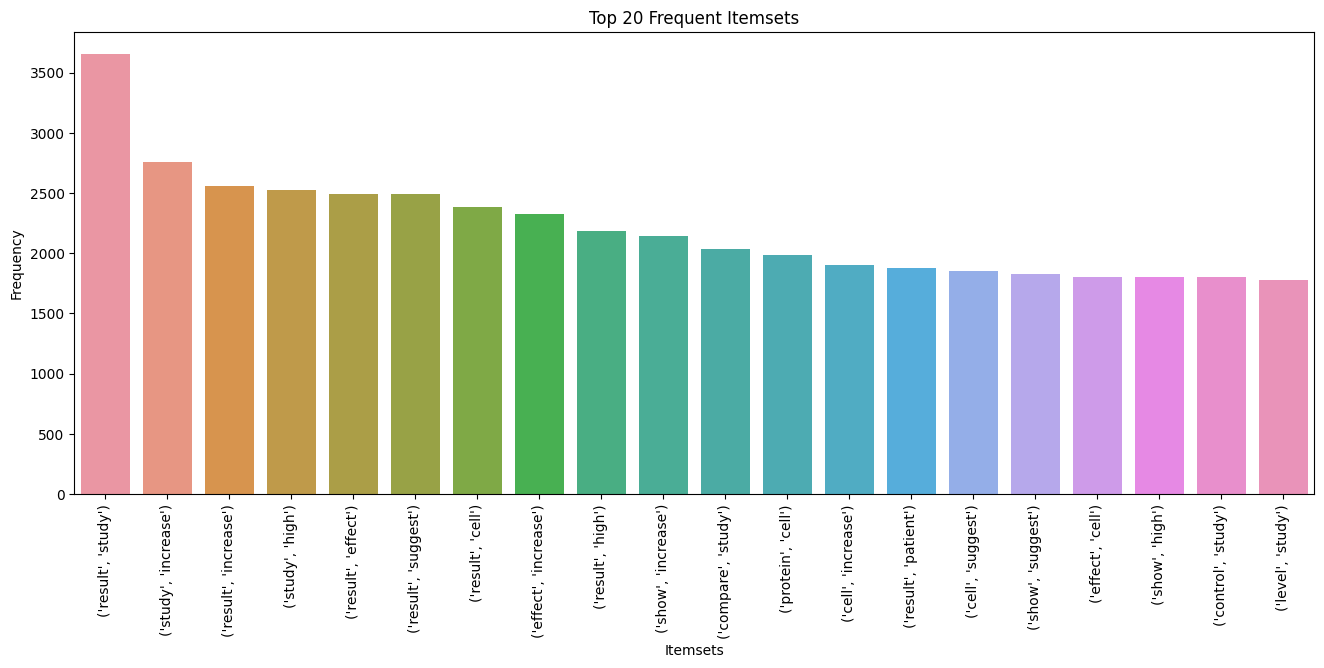

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.barplot(data=sorted_pairs_df, x='items', y='freq')
plt.title('Top 20 Frequent Itemsets')
plt.xlabel('Itemsets')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
